# Microsoft Stock price prediction using Neural Networks (LSTM)

Dataset: https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs


In [46]:
# Importing libraries
import pandas as pd
from datetime import timedelta
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
from typing import List

In [47]:
# Read Microsoft Stock prices Dataset
df = pd.read_csv('msft.us.txt', parse_dates = ['Date'])

In [48]:
# 10 first entries
df.head(10)

,Date,Open,High,Low,Close,Volume,OpenInt
0,1986-03-13,0.06720,0.07533,0.06720,0.07533,1371330506,0
1,1986-03-14,0.07533,0.07533,0.07533,0.07533,409569463,0
2,1986-03-17,0.07533,0.07533,0.07533,0.07533,176995245,0
3,1986-03-18,0.07533,0.07533,0.07533,0.07533,90067008,0
4,1986-03-19,0.07533,0.07533,0.07533,0.07533,63655515,0
5,1986-03-20,0.07533,0.07533,0.06720,0.07533,77665088,0
6,1986-03-21,0.07533,0.07533,0.06720,0.06720,79732075,0
7,1986-03-24,0.06720,0.06720,0.06720,0.06720,86775144,0
8,1986-03-25,0.06720,0.06720,0.06720,0.06720,42641156,0
9,1986-03-26,0.06720,0.07533,0.06720,0.06720,30239240,0


In [49]:
df.shape

(7983, 7)

7983 rows
7 columns

In [50]:
df['Date'].min()

Timestamp('1986-03-13 00:00:00')

<Axes: xlabel='Date'>

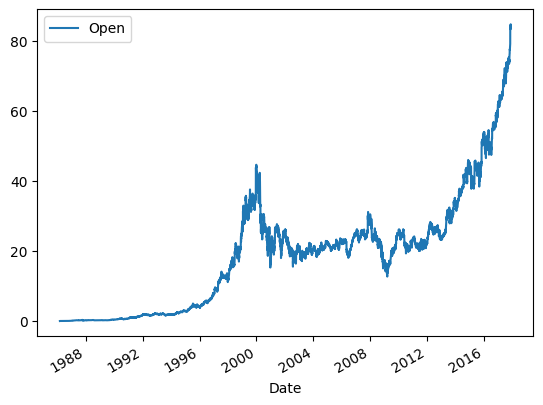

In [51]:
# Microsoft stocks by Date
df.plot(x='Date', y='Open')

In [52]:
# Correlation
df[['Open', 'High', 'Low', 'Close']].corr()

,Open,High,Low,Close
Open,1.000000,0.999886,0.999879,0.999782
High,0.999886,1.000000,0.999820,0.999886
Low,0.999879,0.999820,1.000000,0.999882
Close,0.999782,0.999886,0.999882,1.000000


In [53]:
# Dataframe for 5 years:
df_5_years = df[df['Date'] > df['Date'].max() - timedelta(days=365*5)]

In [54]:
df_5_years

,Date,Open,High,Low,Close,Volume,OpenInt
6723,2012-11-12,25.259,25.321,24.6240,24.630,70004599,0
6724,2012-11-13,23.778,24.026,23.5400,23.840,149637406,0
6725,2012-11-14,23.970,24.016,23.5820,23.620,86466650,0
6726,2012-11-15,23.655,23.735,23.4320,23.461,57895114,0
6727,2012-11-16,23.470,23.497,23.1790,23.339,72827220,0
...,...,...,...,...,...,...,...
7978,2017-11-06,84.200,84.700,84.0825,84.470,19852151,0
7979,2017-11-07,84.770,84.900,83.9300,84.260,17927878,0
7980,2017-11-08,84.140,84.610,83.8300,84.560,18029584,0
7981,2017-11-09,84.110,84.270,82.9000,84.090,21175384,0


In [55]:
df_5_years.shape[0]

1260

In [56]:
# 80% of Data = train
# 20% of Data = test (validation)
train_size = int(df_5_years.shape[0] * 0.8)
train_df = df_5_years.iloc[:train_size]
val_df = df_5_years.iloc[train_size:]

In [57]:
print('Train dataframe shape is ', train_df.shape, '\nTest dataframe shape is ', val_df.shape, sep='')

Train dataframe shape is (1008, 7)
Test dataframe shape is (252, 7)


In [58]:
print('Min Date for train Dataset is', train_df['Date'].min())
print('Max Date for train Dataset is', train_df['Date'].max())

Min Date for train Dataset is 2012-11-12 00:00:00
Max Date for train Dataset is 2016-11-10 00:00:00


In [59]:
print('Min Date for test Dataset is', val_df['Date'].min())
print('Max Date for test Dataset is', val_df['Date'].max())

Min Date for test Dataset is 2016-11-11 00:00:00
Max Date for test Dataset is 2017-11-10 00:00:00


In [60]:
# Normalization
scaler = StandardScaler()
scaler.fit(train_df[['Low']])

StandardScaler()

In [61]:
def make_dataset(
    # Dataframe
    df,
    # Number of elements of time series used to make a prediction
    window_size,
    # Number of elements in batch
    batch_size,
    # Use scaler for Normalization
    use_scaler = True,
    # Mix elements or not
    shuffle = True):
  # To predict the n+1 element n previous elements will be used as features
  # That is why n elements should be subtracted from features
  features = df[['Low']].iloc[:-window_size]
  # Applying Normalization:
  if use_scaler:
    features = scaler.transform(features)
  # Converting Data to type float32
  data = np.array(features, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data = data,
      targets = df['Low'].iloc[window_size:],
      sequence_length = window_size,
      # Number of elements traversed per stride
      sequence_stride = 1,
      shuffle = shuffle,
      batch_size = batch_size)
  return ds

In [62]:
example_ds = make_dataset(df=train_df, window_size=3, batch_size=2, use_scaler=False, shuffle=False)

In [63]:
example_feature, example_label = next(example_ds.as_numpy_iterator())

In [64]:
# Features shape
example_feature.shape
# batch size, number of elements in the sequence, feature size

(2, 3, 1)

In [65]:
example_label.shape
# batch size (number of labels)

(2,)

In [66]:
# First 6 elements of the Dataset
train_df['Low'].iloc[:6]

6723    24.624
6724    23.540
6725    23.582
6726    23.432
6727    23.179
6728    23.292
Name: Low, dtype: float64

In [67]:
print(example_feature[0])
# 3 first elements of the batch

[[24.624]
 [23.54 ]
 [23.582]]


In [68]:
print(example_label[0])
# the 4th element of the Dataset is the label

23.432


In [69]:
print(example_feature[1])

[[23.54 ]
 [23.582]
 [23.432]]


In [70]:
print(example_label[1])

23.179


In [71]:
window_size = 10
batch_size = 8
train_ds = make_dataset(df=train_df, window_size=window_size, batch_size=batch_size, use_scaler=True, shuffle=True)
val_ds = make_dataset(df=val_df, window_size=window_size, batch_size=batch_size, use_scaler=True, shuffle=True)

In [72]:
# In Sequential Class the layers are executed sequentiall. 
# In this case, first LSTM (RNN), then Dense
lstm_model = tf.keras.models.Sequential([    
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(1)
])

In [73]:
def compile_and_fit(model, train_ds, val_ds, num_epochs: int = 20):
  model.compile(
      loss = tf.losses.MeanSquaredError(),
      optimizer = tf.optimizers.Adam(),
      metrics = [tf.metrics.MeanAbsoluteError()]
  )
  history = model.fit(
      train_ds, 
      #num epochs = number of times train dataset samples are used 
      epochs = num_epochs,
      validation_data = val_ds,
      verbose = 0
  )
  return history

In [74]:
history = compile_and_fit(lstm_model, train_ds, val_ds, num_epochs = 100)

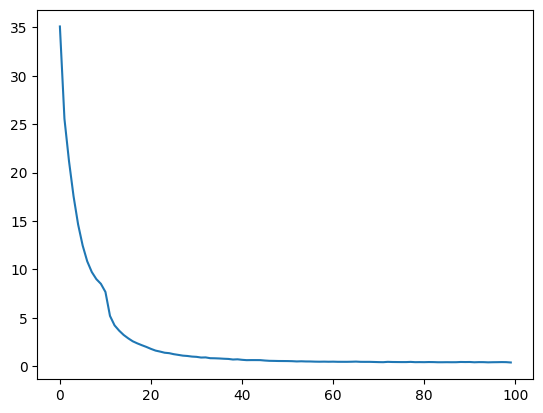

In [75]:
plt.plot(history.history['mean_absolute_error'])

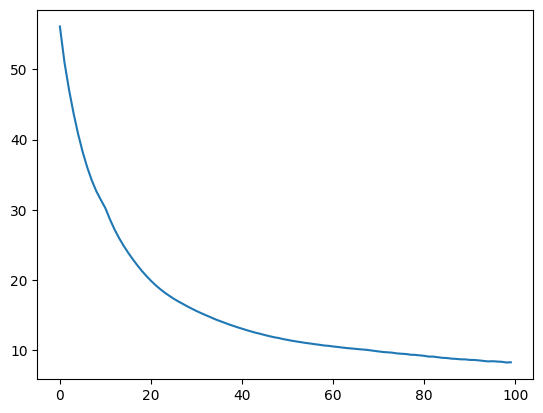

In [76]:
plt.plot(history.history['val_mean_absolute_error'])

In [77]:
lstm_model.evaluate(train_ds)

124/124 [==============================] - 0s 4ms/step - loss: 0.4271 - mean_absolute_error: 0.4498


[0.42710080742836, 0.44977810978889465]

In [78]:
lstm_model.evaluate(val_ds)

30/30 [==============================] - 0s 3ms/step - loss: 95.0061 - mean_absolute_error: 8.2888


[95.00608825683594, 8.288752555847168]

The values are very different. That means the model is retraining itself

In [79]:
# Different number of epochs
lstm_model = tf.keras.models.Sequential([    
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(1)
])

history = compile_and_fit(lstm_model, train_ds, val_ds, num_epochs = 200)

In [80]:
lstm_model.evaluate(train_ds)

124/124 [==============================] - 1s 4ms/step - loss: 0.3803 - mean_absolute_error: 0.4285


[0.3802919387817383, 0.428501158952713]

In [81]:
lstm_model.evaluate(val_ds)

30/30 [==============================] - 0s 4ms/step - loss: 189.0219 - mean_absolute_error: 10.2191


[189.02188110351562, 10.219088554382324]

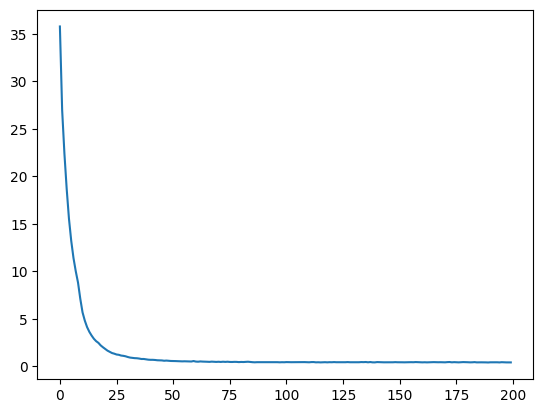

In [82]:
plt.plot(history.history['mean_absolute_error'])

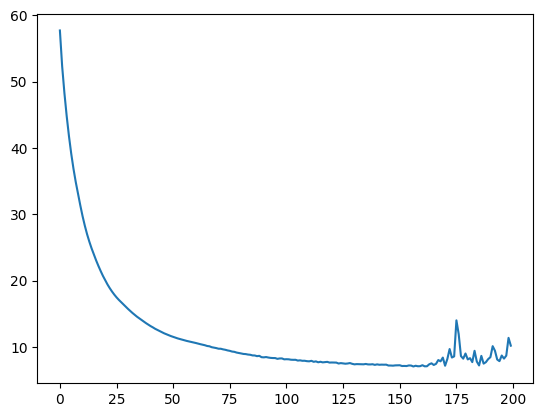

In [83]:
plt.plot(history.history['val_mean_absolute_error'])

The difference in the plots is the process of retraining

In [84]:
# Applying Drop-out method
# Different number of epochs
lstm_model = tf.keras.models.Sequential([    
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

history = compile_and_fit(lstm_model, train_ds, val_ds, num_epochs = 200)

In [85]:
lstm_model.evaluate(train_ds)

124/124 [==============================] - 0s 4ms/step - loss: 0.7548 - mean_absolute_error: 0.6878


[0.7548012137413025, 0.687798023223877]

In [86]:
lstm_model.evaluate(val_ds)

30/30 [==============================] - 0s 4ms/step - loss: 43.2630 - mean_absolute_error: 5.5918


[43.26302719116211, 5.591761112213135]

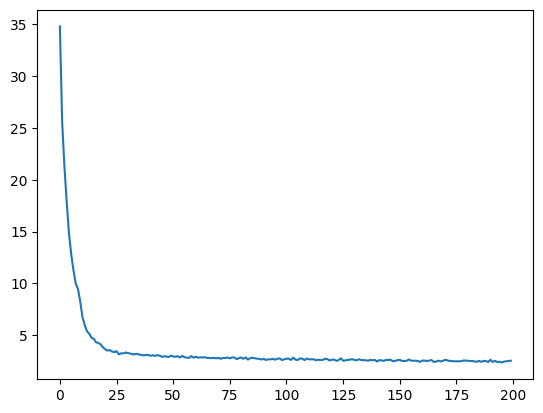

In [87]:
plt.plot(history.history['mean_absolute_error'])

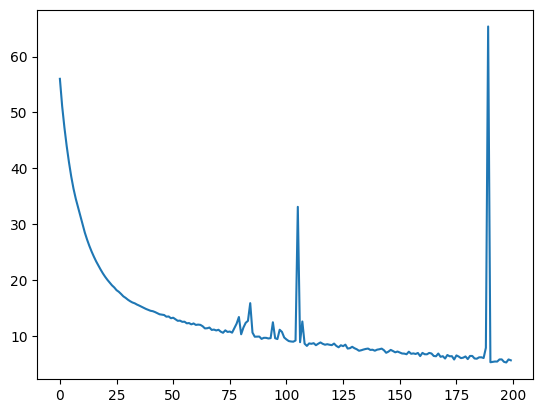

In [88]:
plt.plot(history.history['val_mean_absolute_error'])